# Image pre-reduction

This page will take us through the full pre-reduction of the science images.

You could copy or write the code shown below in a script, or alternatively directly download this page as a {download}`jupyter notebook <./pre-red.ipynb>` file.

Before running the code, make sure you've created and adjusted the module `dataredconfig.py`, as explained [here](./data.md).


In [1]:
import dataredconfig

from pathlib import Path
import numpy as np
import astropy
from astropy import units as u
%matplotlib ipympl
import matplotlib
from matplotlib import pyplot as plt
import ccdproc
import photutils.background

print("numpy", np.__version__, ", astropy", astropy.__version__, ", matplotlib", matplotlib.__version__, ", ccdproc", ccdproc.__version__, ", photutils", photutils.__version__)
# Developed with (Feb 2025): numpy 2.2.2 , astropy 7.0.1 , matplotlib 3.10.0 , ccdproc 2.4.3 , photutils 2.1.0

numpy 2.2.2 , astropy 7.0.1 , matplotlib 3.10.0 , ccdproc  , photutils 2.1.0


In [2]:
# We'll ignore some astropy warnings that get raised as our FITS headers (from NINA) are not 100% standards compliant.
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

## Creating a master-bias

In [3]:
bias_files = ccdproc.ImageFileCollection(dataredconfig.data_dir / "BIAS", keywords=dataredconfig.ifc_header_keywords)
bias_files.summary

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2,DATE-OBS,UTSTART
str37,float64,str1,float64,float64,float64,float64,int64,int64,str10,str8
m42bias_357_2024_00000-23207.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,06:29:20
m42bias_357_2024_00000-23208.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,06:29:26
m42bias_357_2024_00000-23209.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,06:29:31
m42bias_357_2024_00000-23210.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,06:29:36
m42bias_357_2024_00000-23211.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,06:29:41
m42bias_357_2024_00000-23212.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,06:29:46
m42bias_357_2024_00000-23213.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,06:29:52
ngc1672bias_357_2024_00000-23236.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,07:25:54
ngc1672bias_357_2024_00000-23237.fits,--,R,0.0,--,--,--,4096,4096,2024:12:22,07:26:00


In [4]:
# We check the level and noise in these files:
for ccd, filename in bias_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"{filename}: standard deviation {ccd.data.std():.2f} ADU, median level {np.median(ccd.data):.2f} ADU")

m42bias_357_2024_00000-23207.fits: standard deviation 8.81 ADU, median level 1996.00 ADU
m42bias_357_2024_00000-23208.fits: standard deviation 8.79 ADU, median level 1996.00 ADU
m42bias_357_2024_00000-23209.fits: standard deviation 8.79 ADU, median level 1996.00 ADU
m42bias_357_2024_00000-23210.fits: standard deviation 8.79 ADU, median level 1996.00 ADU
m42bias_357_2024_00000-23211.fits: standard deviation 8.79 ADU, median level 1996.00 ADU
m42bias_357_2024_00000-23212.fits: standard deviation 8.79 ADU, median level 1996.00 ADU
m42bias_357_2024_00000-23213.fits: standard deviation 8.79 ADU, median level 1996.00 ADU
ngc1672bias_357_2024_00000-23236.fits: standard deviation 8.81 ADU, median level 1996.00 ADU
ngc1672bias_357_2024_00000-23237.fits: standard deviation 8.81 ADU, median level 1996.00 ADU
ngc1672bias_357_2024_00000-23238.fits: standard deviation 8.80 ADU, median level 1996.00 ADU
ngc1672bias_357_2024_00000-23239.fits: standard deviation 8.79 ADU, median level 1996.00 ADU
ngc16

```{admonition} Question
We'll now build our master-bias by averaging over the bias frames. Assuming that the bias frames contain pure uncorrelated noise (in addition to a prefectly constant bias level), what pixel-to-pixel standard deviation would you expect to observe in the master-bias, and why? Compare this with the actual measurement.
```

In [5]:
combiner = ccdproc.Combiner(bias_files.ccds(ccd_kwargs={"unit":"adu"}))
masterbias = combiner.average_combine()

masterbias.meta['combined'] = True
masterbias.data = masterbias.data.astype('float32') # Converts to float32 to save space
masterbias.write(dataredconfig.work_dir / 'masterbias.fits', overwrite=True)

print(f"masterbias: standard deviation {masterbias.data.std():.2f} ADU, median level {np.median(masterbias.data):.2f} ADU")

masterbias: standard deviation 2.86 ADU, median level 1996.00 ADU


Let's now inspect this master bias visually, to see if it has any structure.

With the code below, you could zoom around in the masterbias. Does it look homogeneous?
We also create a smoothed version of the masterbias, to highlight a bit some (potential) larger scale structures. We will of course not use this smoothed version in the pre-reduction, but it might help to visualize some of the structure.

```{note}
When displaying **any** image, always make sure to adjust the so called **greyscale** (or "brightness" scale, sometimes also called "z-scale" in astronomical software) to properly see whatever structure you want to inspect. In the present case, add the keyword arguments `vmin=?, vmax=?` (with properly chosen values instead of `?`, based for example on the median level computed above) to the call of `plt.imshow()`. These are "cuts" for a linear grey level mapping: pixels with value `vmin` (or below) will be shown as black, and those with value `vmax` (or above) will be shown as white, and everything in between will be mapped to some grey level. If you don't do this, these "cuts" will be automatically selected by some algorithm (often as the minimum and maximum values of the image), and might not be adequate to visualize the details that you want to inspect.
```

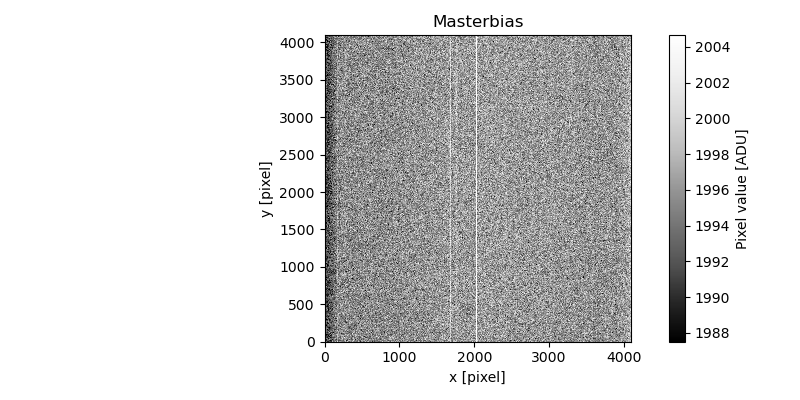

In [6]:
# Median-smoothing the masterbias (only for display purposes):
smooth_masterbias = photutils.background.Background2D(masterbias.data, (100, 100), filter_size=(3, 3), bkg_estimator=photutils.background.MedianBackground()).background

plt.figure(figsize=(8, 4))
plt.title("Masterbias")
cbar = plt.imshow(masterbias, origin='lower', cmap='Greys_r', interpolation='nearest', vmin=np.median(smooth_masterbias)-3*masterbias.data.std(), vmax=np.median(smooth_masterbias)+3*masterbias.data.std())
plt.colorbar(cbar, label="Pixel value [ADU]")
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

## Creating a master-dark

In [7]:
dark_files = ccdproc.ImageFileCollection(dataredconfig.data_dir / "DARK", keywords=dataredconfig.ifc_header_keywords)

# See below if such a filter is needed:
#dark_files = dark_files.filter(exptime=60.0)

dark_files.summary


file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2,DATE-OBS,UTSTART
str37,float64,str1,float64,float64,float64,float64,int64,int64,str10,str8
m42dark_357_2024_00001-23214.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:30:04
m42dark_357_2024_00001-23215.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:31:09
m42dark_357_2024_00001-23216.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:32:14
m42dark_357_2024_00001-23217.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:33:19
m42dark_357_2024_00001-23218.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:34:25
m42dark_357_2024_00001-23219.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:35:30
m42dark_357_2024_00001-23220.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:36:35
ngc1672dark_357_2024_00001-23243.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,07:26:37
ngc1672dark_357_2024_00001-23244.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,07:27:43


In [8]:
# For this simple example we want all darks to have the same exptime.
exptimes = list(set(dark_files.summary["exptime"]))
assert(len(exptimes) == 1) # If this fails, apply some selection to your files.
dark_exptime = exptimes[0]
print("Exposure times of darks: ", dark_exptime)

# As done for the bias frames, let's check the level and noise in these darks:

for ccd, filename in dark_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"{filename}: standard deviation {ccd.data.std():.2f} ADU, median level {np.median(ccd.data):.2f} ADU")

Exposure times of darks:  60.0
m42dark_357_2024_00001-23214.fits: standard deviation 148.37 ADU, median level 1992.00 ADU
m42dark_357_2024_00001-23215.fits: standard deviation 148.37 ADU, median level 1992.00 ADU
m42dark_357_2024_00001-23216.fits: standard deviation 148.53 ADU, median level 1992.00 ADU
m42dark_357_2024_00001-23217.fits: standard deviation 148.12 ADU, median level 1992.00 ADU
m42dark_357_2024_00001-23218.fits: standard deviation 148.04 ADU, median level 1992.00 ADU
m42dark_357_2024_00001-23219.fits: standard deviation 148.13 ADU, median level 1993.00 ADU
m42dark_357_2024_00001-23220.fits: standard deviation 147.91 ADU, median level 1993.00 ADU
ngc1672dark_357_2024_00001-23243.fits: standard deviation 147.00 ADU, median level 1992.00 ADU
ngc1672dark_357_2024_00001-23244.fits: standard deviation 147.22 ADU, median level 1992.00 ADU
ngc1672dark_357_2024_00001-23245.fits: standard deviation 147.19 ADU, median level 1992.00 ADU
ngc1672dark_357_2024_00001-23246.fits: standard

```{admonition} Question
Why is the standard deviation on these dark frames much larger than for bias frames, while the level is almost the same?
```

In [9]:
# Create the masterdark

dest_dir = dataredconfig.work_dir / "DARK_BIASSUB"
dest_dir.mkdir(exist_ok=True)

# First loop over the dark frames to subtract the bias: 
for ccd, filename in dark_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"Processing {filename}...")
    ccd = ccdproc.subtract_bias(ccd, masterbias)
    # Write to disk:
    ccd.data = ccd.data.astype('float32')
    ccd.write(dest_dir / filename, overwrite=True)

# Note: depending on the available memory,
# it might be possible to do this without writing intermediary files,
# following something like:
#dark_ccds = [ccdproc.subtract_bias(ccd, masterbias) for ccd in dark_files.ccds(ccd_kwargs={'unit': 'adu'})]

# Then we combine the files:
files_to_combine = ccdproc.ImageFileCollection(dest_dir).files_filtered(include_path=True)
masterdark = ccdproc.combine(files_to_combine,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=astropy.stats.mad_std,
                                 mem_limit=1e9
                                )

masterdark.meta['combined'] = True
masterdark.data = masterdark.data.astype('float32') # Converts to float32 to save space
masterdark.write(dataredconfig.work_dir / 'masterdark.fits', overwrite=True)


Processing m42dark_357_2024_00001-23214.fits...


Processing m42dark_357_2024_00001-23215.fits...
Processing m42dark_357_2024_00001-23216.fits...
Processing m42dark_357_2024_00001-23217.fits...
Processing m42dark_357_2024_00001-23218.fits...
Processing m42dark_357_2024_00001-23219.fits...
Processing m42dark_357_2024_00001-23220.fits...
Processing ngc1672dark_357_2024_00001-23243.fits...
Processing ngc1672dark_357_2024_00001-23244.fits...
Processing ngc1672dark_357_2024_00001-23245.fits...
Processing ngc1672dark_357_2024_00001-23246.fits...
Processing ngc1672dark_357_2024_00001-23247.fits...
Processing ngc1672dark_357_2024_00001-23248.fits...
Processing ngc1672dark_357_2024_00001-23249.fits...
Processing ngc1672dark_357_2024_00001-23250.fits...
Processing ngc1672dark_357_2024_00001-23251.fits...
Processing ngc1672dark_357_2024_00001-23252.fits...
Processing ngc1672dark_357_2024_00001-23253.fits...
Processing ngc1672dark_357_2024_00001-23254.fits...
Processing ngc1672dark_357_2024_00001-23255.fits...
Processing ngc1672dark_357_2024_0000

INFO:astropy:splitting each image into 17 chunks to limit memory usage to 1000000000.0 bytes.


INFO: splitting each image into 17 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]


Same as for the bias: let's check this for some structure. The median-filtering helps to hide the hot pixels and highlight the larger spatial scales instead. Display the plain `masterdark` to see the hot pixels. Of course we'll later use the plain masterdark without any filtering!



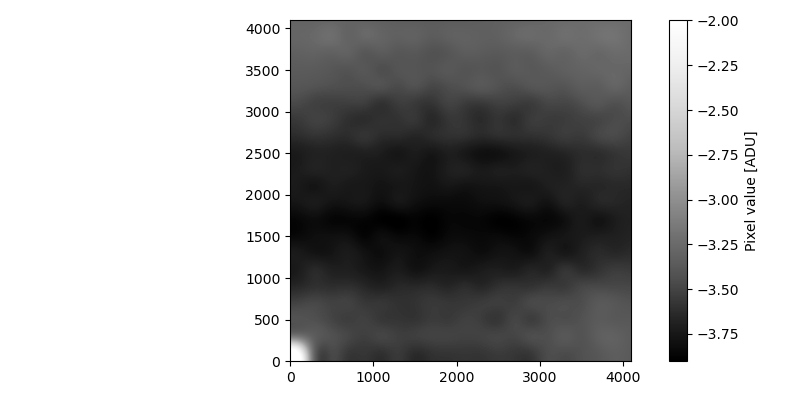

In [10]:
smooth_masterdark = photutils.background.Background2D(masterdark.data, (200, 200), filter_size=(1, 1), bkg_estimator=photutils.background.MedianBackground()).background

plt.figure(figsize=(8, 4))
cbar = plt.imshow(smooth_masterdark, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.colorbar(cbar, label="Pixel value [ADU]")
plt.tight_layout()
plt.show()

```{note} 
As you saw in the code, the masterbias has already been subtracted from this masterdark. So in this figure you should see the effect of the dark current alone.
```

## Creating the master-flats

In [11]:
flat_files = ccdproc.ImageFileCollection(dataredconfig.data_dir / "FLAT", keywords=dataredconfig.ifc_header_keywords)
flat_files.summary

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2,DATE-OBS,UTSTART
str38,float64,str1,float64,float64,float64,float64,int64,int64,str10,str8
ngc1672flatI_357_2024_00002-23283.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:09:18
ngc1672flatI_357_2024_00002-23284.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:09:33
ngc1672flatI_357_2024_00002-23285.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:09:48
ngc1672flatI_357_2024_00002-23286.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:10:03
ngc1672flatI_357_2024_00002-23287.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:10:18
ngc1672flatI_357_2024_00002-23288.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:10:34
ngc1672flatI_357_2024_00002-23289.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:10:49
ngc1672flatI_357_2024_00002-23290.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:11:04
ngc1672flatI_357_2024_00002-23291.fits,--,I,10.0,--,--,--,4096,4096,2024:12:22,09:11:19


In [12]:
# We check the level of these flats.
# The level should ideally stay around 40'000 ADU, and in any case far from saturation!
for ccd, filename in flat_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"{filename}: filter {ccd.header["filter"]}, exptime {ccd.header["exptime"]} s, median level {np.median(ccd.data):.2f} ADU")

ngc1672flatI_357_2024_00002-23283.fits: filter I, exptime 10.0 s, median level 9747.00 ADU
ngc1672flatI_357_2024_00002-23284.fits: filter I, exptime 10.0 s, median level 10174.00 ADU
ngc1672flatI_357_2024_00002-23285.fits: filter I, exptime 10.0 s, median level 10587.00 ADU
ngc1672flatI_357_2024_00002-23286.fits: filter I, exptime 10.0 s, median level 11019.00 ADU
ngc1672flatI_357_2024_00002-23287.fits: filter I, exptime 10.0 s, median level 11476.00 ADU
ngc1672flatI_357_2024_00002-23288.fits: filter I, exptime 10.0 s, median level 11961.00 ADU
ngc1672flatI_357_2024_00002-23289.fits: filter I, exptime 10.0 s, median level 12478.00 ADU
ngc1672flatI_357_2024_00002-23290.fits: filter I, exptime 10.0 s, median level 13028.00 ADU
ngc1672flatI_357_2024_00002-23291.fits: filter I, exptime 10.0 s, median level 13613.00 ADU
ngc1672flatI_357_2024_00002-23292.fits: filter I, exptime 10.0 s, median level 14237.00 ADU
ngc1672flatR_357_2024_00001-23273.fits: filter R, exptime 10.0 s, median level 65

In [13]:
# Scaling function for the flats: they get "normalized" (i.e., divided) by their median:
def inv_median(a):
    return 1 / np.median(a)

In [14]:

# We'll simply loop over these filters:
flat_filters_to_run_on = ["V", "R", "I"]

for selected_filter in flat_filters_to_run_on:

    selected_flat_files = flat_files.filter(filter=selected_filter)
    
    dest_dir = dataredconfig.work_dir / f"FLAT_{selected_filter}_BIASDARKSUB"
    dest_dir.mkdir(exist_ok=True)

    # First subtract bias and dark from every flat:
    for ccd, filename in selected_flat_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
        print(f"Processing {filename}...")
        ccd = ccdproc.subtract_bias(ccd, masterbias)
        ccd = ccdproc.subtract_dark(ccd, masterdark, exposure_time='exptime', exposure_unit=u.second, scale=True)
    
        # Write to disk:
        ccd.data = ccd.data.astype('float32') # Converts to float32 to save space
        ccd.write(dest_dir / filename, overwrite=True)


    # And now combine to a masterflat:
    files_to_combine = ccdproc.ImageFileCollection(dest_dir).files_filtered(include_path=True)
    masterflat = ccdproc.combine(files_to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=astropy.stats.mad_std,
                                 mem_limit=1e9
                                )

    masterflat.meta['combined'] = True
    masterflat.data = masterflat.data.astype('float32') # Converts to float32 to save space
    masterflat.write(dataredconfig.work_dir / f"masterflat_{selected_filter}.fits", overwrite=True)

Processing ngc1672flatV_357_2024_00000-23263.fits...
Processing ngc1672flatV_357_2024_00000-23264.fits...
Processing ngc1672flatV_357_2024_00000-23265.fits...
Processing ngc1672flatV_357_2024_00000-23266.fits...
Processing ngc1672flatV_357_2024_00000-23267.fits...
Processing ngc1672flatV_357_2024_00000-23268.fits...
Processing ngc1672flatV_357_2024_00000-23269.fits...
Processing ngc1672flatV_357_2024_00000-23270.fits...
Processing ngc1672flatV_357_2024_00000-23271.fits...
Processing ngc1672flatV_357_2024_00000-23272.fits...


INFO:astropy:splitting each image into 8 chunks to limit memory usage to 1000000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
Processing ngc1672flatR_357_2024_00001-23273.fits...
Processing ngc1672flatR_357_2024_00001-23274.fits...
Processing ngc1672flatR_357_2024_00001-23275.fits...
Processing ngc1672flatR_357_2024_00001-23276.fits...
Processing ngc1672flatR_357_2024_00001-23277.fits...
Processing ngc1672flatR_357_2024_00001-23278.fits...
Processing ngc1672flatR_357_2024_00001-23279.fits...
Processing ngc1672flatR_357_2024_00001-23280.fits...
Processing ngc1672flatR_357_2024_00001-23281.fits...
Processing ngc1672flatR_357_2024_00001-23282.fits...


INFO:astropy:splitting each image into 8 chunks to limit memory usage to 1000000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
Processing ngc1672flatI_357_2024_00002-23283.fits...
Processing ngc1672flatI_357_2024_00002-23284.fits...
Processing ngc1672flatI_357_2024_00002-23285.fits...
Processing ngc1672flatI_357_2024_00002-23286.fits...
Processing ngc1672flatI_357_2024_00002-23287.fits...
Processing ngc1672flatI_357_2024_00002-23288.fits...
Processing ngc1672flatI_357_2024_00002-23289.fits...
Processing ngc1672flatI_357_2024_00002-23290.fits...
Processing ngc1672flatI_357_2024_00002-23291.fits...
Processing ngc1672flatI_357_2024_00002-23292.fits...


INFO:astropy:splitting each image into 8 chunks to limit memory usage to 1000000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]


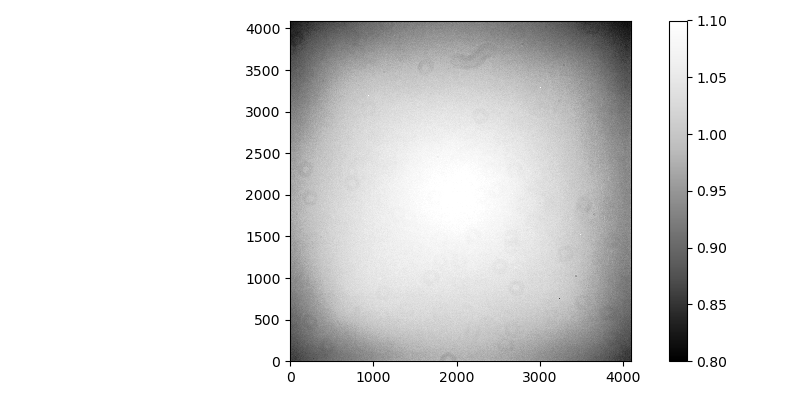

In [19]:
# Checking the masterflats

masterflat = ccdproc.CCDData.read(dataredconfig.work_dir / "masterflat_R.fits")
plt.figure(figsize=(8, 4))
cbar = plt.imshow(masterflat.data, vmin=0.8, vmax=1.10, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.colorbar(cbar)
plt.tight_layout()
plt.show()


## Processing the science images

In [16]:
science_files = ccdproc.ImageFileCollection(dataredconfig.data_dir / "LIGHT", keywords=dataredconfig.ifc_header_keywords)
science_files.summary

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2,DATE-OBS,UTSTART
str35,float64,str1,float64,float64,float64,float64,int64,int64,str10,str8
ngc1672_I_357_2024_00005-23231.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:13:43
ngc1672_I_357_2024_00006-23232.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:15:03
ngc1672_I_357_2024_00007-23233.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:16:22
ngc1672_I_357_2024_00008-23234.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:17:41
ngc1672_I_357_2024_00009-23235.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:18:58
ngc1672_R_357_2024_00000-23221.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:52:56
ngc1672_R_357_2024_00001-23222.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:54:16
ngc1672_R_357_2024_00002-23223.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:55:35
ngc1672_R_357_2024_00003-23224.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:56:56


In [17]:

# Defining the directory where pre-reduced images should be written:
dest_dir = dataredconfig.work_dir / "LIGHT_PRERED"
dest_dir.mkdir(exist_ok=True)

# Reading in from disk the master calibration frames:
masterbias = ccdproc.CCDData.read(dataredconfig.work_dir / "masterbias.fits")
masterdark = ccdproc.CCDData.read(dataredconfig.work_dir / "masterdark.fits")
# For the flats, we build a dictionnary that holds the masterflat for each filter name:
available_flat_filters = flat_filters_to_run_on #["g", "r", "i"]
masterflats = {filtername: ccdproc.CCDData.read(dataredconfig.work_dir / f"masterflat_{filtername}.fits") for filtername in available_flat_filters}

n_files = len(science_files.summary)
# We loop over all files, selecting the right masterflat on the fly
for (i, (ccd, filename)) in enumerate(science_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True)):
    print(f"=== Processing image {i+1}/{n_files}: {filename} ===")
    ccd = ccdproc.subtract_bias(ccd, masterbias)
    ccd = ccdproc.subtract_dark(ccd, masterdark, exposure_time='exptime', exposure_unit=u.second, scale=True)
    
    masterflat_to_use = masterflats[ccd.header['filter']]
    ccd = ccdproc.flat_correct(ccd, masterflat_to_use)
    
    # Write to disk:
    ccd.data = ccd.data.astype('float32') # Converts to float32 to save space
    ccd.write(dest_dir / filename, overwrite=True)

=== Processing image 1/15: ngc1672_I_357_2024_00005-23231.fits ===
=== Processing image 2/15: ngc1672_I_357_2024_00006-23232.fits ===
=== Processing image 3/15: ngc1672_I_357_2024_00007-23233.fits ===
=== Processing image 4/15: ngc1672_I_357_2024_00008-23234.fits ===
=== Processing image 5/15: ngc1672_I_357_2024_00009-23235.fits ===
=== Processing image 6/15: ngc1672_R_357_2024_00000-23221.fits ===
=== Processing image 7/15: ngc1672_R_357_2024_00001-23222.fits ===
=== Processing image 8/15: ngc1672_R_357_2024_00002-23223.fits ===
=== Processing image 9/15: ngc1672_R_357_2024_00003-23224.fits ===
=== Processing image 10/15: ngc1672_R_357_2024_00004-23225.fits ===
=== Processing image 11/15: ngc1672_V_357_2024_00000-23226.fits ===
=== Processing image 12/15: ngc1672_V_357_2024_00001-23227.fits ===
=== Processing image 13/15: ngc1672_V_357_2024_00002-23228.fits ===
=== Processing image 14/15: ngc1672_V_357_2024_00003-23229.fits ===
=== Processing image 15/15: ngc1672_V_357_2024_00004-2323